In [229]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import linregress
import ast



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [161]:
matchesSpain = pd.read_csv('data/matches_Spain.csv')
matchesItaly = pd.read_csv('data/matches_Italy.csv')
matchesGermany = pd.read_csv('data/matches_Germany.csv')
matchesFrance= pd.read_csv('data/matches_France.csv')

In [162]:
matchesSpain[['status','roundId','seasonId','duration','competitionId','team1.scoreET','team1.scoreP','team1.hasFormation','team2.scoreET','team2.scoreP','team2.hasFormation']].drop_duplicates()

,status,roundId,seasonId,duration,competitionId,team1.scoreET,team1.scoreP,team1.hasFormation,team2.scoreET,team2.scoreP,team2.hasFormation
0,Played,4406122,181144,Regular,795,0,0,1,0,0,1


In [163]:
matches=pd.concat((matchesSpain,matchesItaly,matchesGermany,matchesFrance), axis=0)

In [164]:
len(matches)==len(matchesSpain)+len(matchesItaly)+len(matchesGermany)+len(matchesFrance)

True

In [165]:
matches[['status','duration','team1.scoreET','team1.scoreP','team1.hasFormation','team2.scoreET','team2.scoreP','team2.hasFormation']].drop_duplicates()

,status,duration,team1.scoreET,team1.scoreP,team1.hasFormation,team2.scoreET,team2.scoreP,team2.hasFormation
0,Played,Regular,0,0,1,0,0,1


In [166]:
matches.drop(['status','duration','team1.scoreET','team1.scoreP','team1.hasFormation','team2.scoreET','team2.scoreP','team2.hasFormation'],
             axis=1, inplace=True)

We can drop roundId,seasonId,competitionId too because we are treating all competitions alike. I will be training on Spain, Italy, Germany and France to predict on England. So keeping track of the id's isnt useful.

In [167]:
matches.drop(['roundId','seasonId','competitionId'],
             axis=1, inplace=True)

In [168]:
matches.columns

Index(['gameweek', 'teamsData', 'dateutc', 'winner', 'venue', 'wyId', 'label',
       'date', 'referees', 'team1.coachId', 'team1.side', 'team1.teamId',
       'team1.score', 'team1.formation', 'team1.scoreHT',
       'team1.formation.bench', 'team1.formation.lineup',
       'team1.formation.substitutions', 'team2.coachId', 'team2.side',
       'team2.teamId', 'team2.score', 'team2.formation', 'team2.scoreHT',
       'team2.formation.bench', 'team2.formation.lineup',
       'team2.formation.substitutions'],
      dtype='object')

Also dropping a lot of additional columns for my initial ML model. 

In [169]:
matches.drop(['teamsData',   'venue', 
                'date', 'referees', 'team1.coachId', 
                'team1.formation', 'team1.scoreHT',
                'team1.formation.bench', 'team1.formation.lineup',
                'team1.formation.substitutions', 'team2.coachId',
                'team2.formation', 'team2.scoreHT',
                'team2.formation.bench', 'team2.formation.lineup',
                'team2.formation.substitutions'],
            axis=1, inplace=True)


In [170]:
matches=matches.sort_values(by='dateutc').reset_index(drop=True)

In [171]:
matches

,gameweek,dateutc,winner,wyId,label,team1.side,team1.teamId,team1.score,team2.side,team2.teamId,team2.score
0,1,2017-08-04 18:45:00,19830,2500691,"Monaco - Toulouse, 3 - 2",away,3780,2,home,19830,3
1,1,2017-08-05 15:15:00,3767,2500693,"PSG - Amiens SC, 2 - 0",home,3767,2,away,3789,0
2,1,2017-08-05 18:00:00,3782,2500694,"Saint-\u00c9tienne - Nice, 1 - 0",away,3775,0,home,3782,1
3,1,2017-08-05 18:00:00,3787,2500692,"Montpellier - Caen, 1 - 0",away,3783,0,home,3787,1
4,1,2017-08-05 18:00:00,3785,2500690,"Metz - Guingamp, 1 - 3",home,3777,1,away,3785,3
...,...,...,...,...,...,...,...,...,...,...,...
1441,38,2018-05-20 16:00:00,3204,2576337,"SPAL - Sampdoria, 3 - 1",away,3164,1,home,3204,3
1442,38,2018-05-20 16:30:00,0,2565925,"Atl\u00e9tico Madrid - Eibar, 2 - 2",home,679,2,away,701,2
1443,38,2018-05-20 18:45:00,3158,2576336,"Sassuolo - Roma, 0 - 1",away,3158,1,home,3315,0
1444,38,2018-05-20 18:45:00,3161,2576335,"Lazio - Internazionale, 2 - 3",home,3162,2,away,3161,3


##### Now I want to replace the winner, team1.teamId, team2.teamId with the team names.

Creating a team mapping dictionary

In [172]:
teams=pd.read_csv('data/teams.csv')
teams.head()
team_mapping=teams.set_index('wyId')['name'].to_dict()

In [173]:
matches['team1.teamId']=matches['team1.teamId'].map(team_mapping)
matches['team2.teamId']=matches['team2.teamId'].map(team_mapping)
matches['winner']=matches['winner'].map(team_mapping)

In [174]:
matches.rename(columns={'team1.teamId':'team1.teamName','team2.teamId':'team2.teamName'}, inplace=True)

#### I want all home teams on the left, all the away teams on the right. And I want it labeled home and away instead of team1 and team2

(as was done in the feature planning file)

In [175]:
home_teams1 = matches[matches['team1.side'] == 'home'].copy()
home_teams1 = home_teams1[['team1.side', 'team1.teamName', 'team1.score']]
home_teams1.columns=['home.side', 'home.teamName', 'home.score']

home_teams2 = matches[matches['team2.side'] == 'home'].copy()
home_teams2 = home_teams2[['team2.side', 'team2.teamName', 'team2.score']]
home_teams2.columns = ['home.side', 'home.teamName', 'home.score']

home_teams=pd.concat([home_teams1, home_teams2], axis=0).sort_index()

In [176]:
away_teams1 = matches[matches['team1.side'] == 'away'].copy()
away_teams1 = away_teams1[['team1.side', 'team1.teamName', 'team1.score']]
away_teams1.columns=['away.side', 'away.teamName', 'away.score']

away_teams2 = matches[matches['team2.side'] == 'away'].copy()
away_teams2 = away_teams2[['team2.side', 'team2.teamName', 'team2.score']]
away_teams2.columns = ['away.side', 'away.teamName', 'away.score']

away_teams=pd.concat([away_teams1, away_teams2], axis=0).sort_index()

In [177]:
match_cols = matches[['gameweek','wyId', 'dateutc', 'winner', 'label']]

In [178]:
matches = pd.concat([match_cols , home_teams, away_teams], axis = 1)

In [179]:
matches.head()

,gameweek,wyId,dateutc,winner,label,home.side,home.teamName,home.score,away.side,away.teamName,away.score
0,1,2500691,2017-08-04 18:45:00,Monaco,"Monaco - Toulouse, 3 - 2",home,Monaco,3,away,Toulouse,2
1,1,2500693,2017-08-05 15:15:00,PSG,"PSG - Amiens SC, 2 - 0",home,PSG,2,away,Amiens SC,0
2,1,2500694,2017-08-05 18:00:00,Saint-\u00c9tienne,"Saint-\u00c9tienne - Nice, 1 - 0",home,Saint-\u00c9tienne,1,away,Nice,0
3,1,2500692,2017-08-05 18:00:00,Montpellier,"Montpellier - Caen, 1 - 0",home,Montpellier,1,away,Caen,0
4,1,2500690,2017-08-05 18:00:00,Guingamp,"Metz - Guingamp, 1 - 3",home,Metz,1,away,Guingamp,3


### Some grouping to get the average goals scored

##### grouping by match and home team

In [180]:
numHomeGoals=matches.groupby(['dateutc','wyId','home.teamName'])['home.score'].first().reset_index()
numHomeGoals.rename(columns={'home.teamName':'teamName','home.score':'NumGoals'}, inplace=True)

##### grouping by match and home team

In [181]:
numAwayGoals=matches.groupby(['dateutc','wyId','away.teamName'])['away.score'].first().reset_index()
numAwayGoals.rename(columns={'away.teamName':'teamName','away.score':'NumGoals'}, inplace=True)


In [182]:
allgoals=pd.concat([numHomeGoals,numAwayGoals],axis=0).sort_values(by="dateutc")

In [183]:
allgoals

,dateutc,wyId,teamName,NumGoals
0,2017-08-04 18:45:00,2500691,Monaco,3
0,2017-08-04 18:45:00,2500691,Toulouse,2
1,2017-08-05 15:15:00,2500693,PSG,2
1,2017-08-05 15:15:00,2500693,Amiens SC,0
2,2017-08-05 18:00:00,2500688,Olympique Lyonnais,4
...,...,...,...,...
1445,2018-05-20 18:45:00,2576336,Sassuolo,0
1444,2018-05-20 18:45:00,2576335,Lazio,2
1443,2018-05-20 18:45:00,2565922,Barcelona,1
1444,2018-05-20 18:45:00,2576335,Internazionale,3


In [184]:
# Calculate cumulative mean excluding the current row's goals
allgoals['GoalsPerGame'] = allgoals.groupby('teamName')['NumGoals'].transform(
    lambda x: x.shift(1).cumsum() / x.shift(1).expanding().count()
)


In [185]:
# Calculate rolling mean over the last 5 rows excluding the current row's goals
allgoals['GoalsPerGame_last5'] = allgoals.groupby('teamName')['NumGoals'].transform(
    lambda x: x.shift(1).rolling(window=5, min_periods=1).mean()
)

In [186]:
matches=matches.merge(
    allgoals, 
    how='left', 
    left_on=['wyId','home.teamName'], 
    right_on=['wyId','teamName'],
    suffixes=('','_y')
).rename(columns={'GoalsPerGame':'home.GoalsPerGame', 'GoalsPerGame_last5':'home.GoalsPerGame_last5'})

matches.drop(['dateutc_y','teamName','NumGoals'], axis=1, inplace=True)

In [187]:
matches=matches.merge(
    allgoals, 
    how='left', 
    left_on=['wyId','away.teamName'], 
    right_on=['wyId','teamName'],
    suffixes=('','_y')
).rename(columns={'GoalsPerGame':'away.GoalsPerGame', 'GoalsPerGame_last5':'away.GoalsPerGame_last5'})

matches.drop(['dateutc_y','teamName','NumGoals'], axis=1, inplace=True)

### Some grouping to get the average goals conceded

In [188]:
numHomeConceded=matches.groupby(['dateutc','wyId','home.teamName'])['away.score'].first().reset_index()
numHomeConceded.rename(columns={'home.teamName':'teamName','away.score':'NumConceded'}, inplace=True)

In [189]:
numAwayConceded=matches.groupby(['dateutc','wyId','away.teamName'])['home.score'].first().reset_index()
numAwayConceded.rename(columns={'away.teamName':'teamName','home.score':'NumConceded'}, inplace=True)

In [190]:
allConceded=pd.concat([numHomeConceded,numAwayConceded],axis=0).sort_values(by="dateutc")

In [191]:
# Calculate cumulative mean excluding the current row's goals
allConceded['ConcededPerGame'] = allConceded.groupby('teamName')['NumConceded'].transform(
    lambda x: x.shift(1).cumsum() / x.shift(1).expanding().count()
)


In [192]:
# Calculate rolling mean over the last 5 rows excluding the current row's goals
allConceded['ConcededPerGame_last5'] = allConceded.groupby('teamName')['NumConceded'].transform(
    lambda x: x.shift(1).rolling(window=5, min_periods=1).mean()
)

In [193]:
matches=matches.merge(
    allConceded, 
    how='left', 
    left_on=['wyId','home.teamName'], 
    right_on=['wyId','teamName'],
    suffixes=('','_y')
).rename(columns={'ConcededPerGame':'home.ConcededPerGame', 'ConcededPerGame_last5':'home.ConcededPerGame_last5'})

matches.drop(['dateutc_y','teamName','NumConceded'], axis=1, inplace=True)

In [194]:
matches=matches.merge(
    allConceded, 
    how='left', 
    left_on=['wyId','away.teamName'], 
    right_on=['wyId','teamName'],
    suffixes=('','_y')
).rename(columns={'ConcededPerGame':'away.ConcededPerGame', 'ConcededPerGame_last5':'away.ConcededPerGame_last5'})

matches.drop(['dateutc_y','teamName','NumConceded'], axis=1, inplace=True)

In [195]:
matches[(matches['home.teamName']=='Barcelona')| (matches['away.teamName']=='Barcelona')].head(5)

,gameweek,wyId,dateutc,winner,label,home.side,home.teamName,home.score,away.side,away.teamName,away.score,home.GoalsPerGame,home.GoalsPerGame_last5,away.GoalsPerGame,away.GoalsPerGame_last5,home.ConcededPerGame,home.ConcededPerGame_last5,away.ConcededPerGame,away.ConcededPerGame_last5
47,1,2565554,2017-08-20 18:15:00,Barcelona,"Barcelona - Real Betis, 2 - 0",home,Barcelona,2,away,Real Betis,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71,2,2565559,2017-08-26 16:15:00,Barcelona,"Deportivo Alav\u00e9s - Barcelona, 0 - 2",home,Deportivo Alav\u00e9s,0,away,Barcelona,2,0.000000,0.000000,2.0,2.0,1.000000,1.000000,0.0,0.0
117,3,2565577,2017-09-09 18:45:00,Barcelona,"Barcelona - Espanyol, 5 - 0",home,Barcelona,5,away,Espanyol,0,2.000000,2.000000,0.5,0.5,0.000000,0.000000,1.0,1.0
145,4,2565580,2017-09-16 14:15:00,Barcelona,"Getafe - Barcelona, 1 - 2",home,Getafe,1,away,Barcelona,2,0.666667,0.666667,3.0,3.0,0.666667,0.666667,0.0,0.0
181,5,2565592,2017-09-19 20:00:00,Barcelona,"Barcelona - Eibar, 6 - 1",home,Barcelona,6,away,Eibar,1,2.750000,2.750000,0.5,0.5,0.250000,0.250000,1.0,1.0


In [196]:
matches.columns

Index(['gameweek', 'wyId', 'dateutc', 'winner', 'label', 'home.side',
       'home.teamName', 'home.score', 'away.side', 'away.teamName',
       'away.score', 'home.GoalsPerGame', 'home.GoalsPerGame_last5',
       'away.GoalsPerGame', 'away.GoalsPerGame_last5', 'home.ConcededPerGame',
       'home.ConcededPerGame_last5', 'away.ConcededPerGame',
       'away.ConcededPerGame_last5'],
      dtype='object')

In [197]:
matches.drop(columns=['wyId', 'dateutc','home.side','away.side'], inplace=True)

In [198]:
#rearranging column order

matches=matches[['winner', 'label','gameweek', 'home.teamName', 'home.score', 'away.teamName',
       'away.score', 'home.GoalsPerGame', 'home.GoalsPerGame_last5', 'home.ConcededPerGame',
       'home.ConcededPerGame_last5','away.GoalsPerGame', 'away.GoalsPerGame_last5', 'away.ConcededPerGame',
       'away.ConcededPerGame_last5']]

In [199]:
matches = matches.copy()

matches['result'] = np.where(matches['winner'] == matches['home.teamName'], 'H',
                        np.where(matches['winner'] == matches['away.teamName'], 'A', 'D'))

In [200]:
#winner and match labels are no longer needed
matches.drop(columns=['winner','label'], inplace=True)

In [201]:
#team names and team scores are now no longer needed
matches.drop(columns=['home.teamName','home.score','away.teamName','away.score'], inplace=True)

In [205]:
#filtering only where gameweek is 6th or more. This is because I am using the results from the last 5 games. 
matches=matches[matches['gameweek']>=6]

In [207]:
#gameweek
matches.drop(columns=['gameweek'], inplace=True)

In [208]:
matches

,home.GoalsPerGame,home.GoalsPerGame_last5,home.ConcededPerGame,home.ConcededPerGame_last5,away.GoalsPerGame,away.GoalsPerGame_last5,away.ConcededPerGame,away.ConcededPerGame_last5,result
137,1.600000,1.6,2.200000,2.2,1.800000,1.8,1.200000,1.2,A
146,2.800000,2.8,1.600000,1.6,0.800000,0.8,1.600000,1.6,H
150,0.800000,0.8,1.000000,1.0,0.600000,0.6,1.000000,1.0,A
151,1.200000,1.2,2.400000,2.4,1.200000,1.2,0.800000,0.8,A
152,1.200000,1.2,1.600000,1.6,0.800000,0.8,1.200000,1.2,H
...,...,...,...,...,...,...,...,...,...
1441,0.972973,1.2,1.567568,1.2,1.486486,1.0,1.540541,1.6,H
1442,1.513514,0.4,0.540541,1.0,1.135135,1.2,1.297297,0.4,D
1443,0.783784,1.2,1.567568,1.0,1.621622,2.0,0.756757,0.4,A
1444,2.351351,2.4,1.243243,1.2,1.702703,2.6,0.756757,1.2,A


In [218]:
matches[['result']].value_counts().reset_index()

,result,count
0,H,563
1,A,377
2,D,311


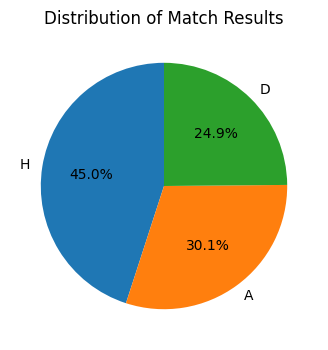

In [220]:

# Calculate value counts for 'result' column
result_counts = matches['result'].value_counts()

# Plot pie chart
plt.figure(figsize=(4, 4))
plt.pie(result_counts, labels=result_counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Distribution of Match Results")
plt.show()


In [222]:
# Step 1: Prepare data and label encode
# Assuming 'matches' is your DataFrame
X = matches.drop(columns=['result'])
y = matches['result']
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # 'H'=0, 'A'=1, 'D'=2

In [223]:
y

array([0, 2, 0, ..., 0, 0, 2])

In [225]:

# Step 2: Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [226]:
# Step 3: Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [227]:
# Step 4: Train a model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [228]:
# Step 5: Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy:.2f}")


Model accuracy: 0.51


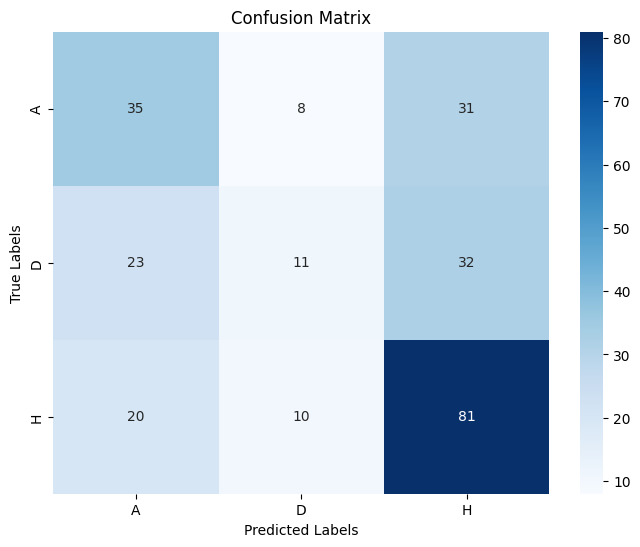

Classification Report:
               precision    recall  f1-score   support

           A       0.45      0.47      0.46        74
           D       0.38      0.17      0.23        66
           H       0.56      0.73      0.64       111

    accuracy                           0.51       251
   macro avg       0.46      0.46      0.44       251
weighted avg       0.48      0.51      0.48       251



In [230]:



# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Classification report
class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print("Classification Report:\n", class_report)
